# Images for text

100%|██████████| 50/50 [00:03<00:00, 15.96it/s]


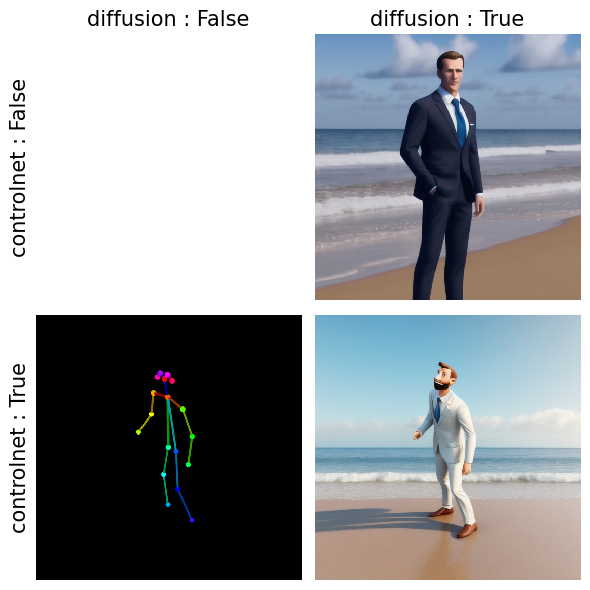

In [58]:
import seaborn_image as isns
import torch
import numpy as np
from diffusers import AutoencoderKL, ControlNetModel, MotionAdapter
from diffusers.pipelines import (
    AutoPipelineForText2Image,
    StableDiffusionControlNetPipeline,
)
from PIL import Image
import matplotlib.pyplot as plt

generator = torch.Generator(device="cuda").manual_seed(12)

isns.set_save_context(dpi=300)
isns.set_context("paper", fontweight="normal")

prompt = "animated man in suit standing on a beach, best quality, masterpiece"

controlnet_image = Image.open("data/controlnet_openpose.png")

model_id = "SG161222/Realistic_Vision_V5.1_noVAE"
controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/control_v11p_sd15_openpose", torch_dtype=torch.float16
)

pipe = AutoPipelineForText2Image.from_pretrained(
    model_id, torch_dtype=torch.float16
).to("cuda")

pipe_controlnet = StableDiffusionControlNetPipeline.from_pretrained(
    model_id, controlnet=controlnet, torch_dtype=torch.float16, use_safetensors=True
).to("cuda")

output = np.array(pipe(prompt, generator=generator).images[0])
output_controlnet = np.array(pipe_controlnet(prompt, image=controlnet_image, generator=generator).images[0])


def map_func(*args, **kwargs):
    if not kwargs["controlnet"] and not kwargs["diffusion"]:
        return np.ones_like(output) * 255
    elif kwargs["controlnet"] and kwargs["diffusion"]:
        return output_controlnet
    elif kwargs["controlnet"] and not kwargs["diffusion"]:
        return np.array(controlnet_image)
    return output


g = isns.ParamGrid(
    output,
    row="controlnet",
    col="diffusion",
    map_func=map_func,
    controlnet=[False, True],
    diffusion=[False, True],
    despine=True
)

plt.savefig("images/controlnet.png")

100%|██████████| 50/50 [00:02<00:00, 17.19it/s]


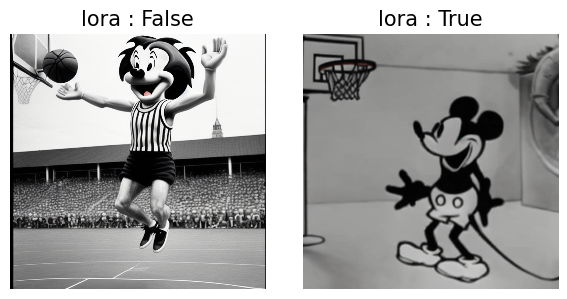

In [77]:
import seaborn_image as isns
import torch
import numpy as np
from diffusers import AutoencoderKL, ControlNetModel, MotionAdapter
from diffusers.pipelines import (
    AutoPipelineForText2Image,
    StableDiffusionControlNetPipeline,
)
from PIL import Image
import matplotlib.pyplot as plt

generator = torch.Generator(device="cuda").manual_seed(11)

isns.set_save_context(dpi=300)
isns.set_context("paper", fontweight="normal")

prompt = "steamboat willie jumping, playing basketball, best quality, masterpiece"

model_id = "SG161222/Realistic_Vision_V5.1_noVAE"

pipe = AutoPipelineForText2Image.from_pretrained(
    model_id, torch_dtype=torch.float16
).to("cuda")

pipe_lora = AutoPipelineForText2Image.from_pretrained(
    model_id, torch_dtype=torch.float16, use_safetensors=True
).to("cuda")
pipe_lora.load_lora_weights("lora/Willie.safetensors", 'willie')
pipe.set_adapters(["willie"], adapter_weights=[0.8])

output = np.array(pipe(prompt, generator=generator).images[0])
output_lora = np.array(pipe_lora(prompt, generator=generator).images[0])

def map_func(*args, **kwargs):
    if kwargs["lora"]:
        return output_lora
    return output


g = isns.ParamGrid(
    output,
    col="lora",
    map_func=map_func,
    lora=[False, True],
    despine=True
)

plt.savefig("images/lora.png")